In [10]:
from moleculekit.molecule import Molecule
import jax_md
import os
# load alanine dipeptide
testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

In [3]:
# mol.write('data/prod_alanine_dipeptide_amber/from_prmtop.pdb')

In [11]:
# use this utility from torchmd, since it doesn't require torch (could port and remove dependency on torchmd altogether)
from torchmd.forcefields.forcefield import ForceField
ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))

In [12]:
from parameters import Parameters, set_box, set_positions
import jax.numpy as nnp

In [13]:
parameters = Parameters(ff, mol, precision=float, device='cpu')
nreplicas = 1 # don't change
pos = set_positions(nreplicas, mol.coords)
box = nnp.array(set_box(nreplicas, mol.box), dtype='float32')


In [14]:
from forces import Forces
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])

Calculating the potential should result in the same value, -2190.6, as the original TorchMD code at https://github.com/torchmd/torchmd/blob/master/examples/tutorial.ipynb:

In [15]:
forces.compute(pos, box)

/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter 

Array(-2190.6232048, dtype=float64)

In [16]:
# plotting utilities

import numpy.linalg as npl
# import seaborn as sns
import matplotlib.pyplot as plt 
from plotting import rama_plot
from jax_md.simulate import Sampler
from jax_md import space, quantity
from jax_md import simulate, energy
import math
import jax

In [57]:
BOLTZMAN = 0.001987191
T = 300
# nlogp = lambda x : (x**2).sum()/2
nlogp = lambda x : forces.compute(nnp.reshape(x, pos.shape), box)
energy_fn = lambda x : nlogp(x) / (BOLTZMAN * T)
value_grad = jax.value_and_grad(energy_fn)

class MD():


  def __init__(self, d):
    self.d = d

  def grad_nlogp(self, x):
    return value_grad(x)

  def transform(self, x):
    return x

  def prior_draw(self, key):
    return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


displacement_fn, shift_fn = space.periodic(box[0][0][0].item())
# displacement_fn, shift_fn = space.periodic_general(box[0])

# kg**{1/2}*m = (1000*Av*g/Av)**{1/2}*1e-10A = nnp.sqrt(1000*Av)*nnp.sqrt(g)*1e-10A

eps_in_si = 3*scipy.constants.femto * nnp.sqrt(3 * 688 * scipy.constants.k * T)
si_to_gmol = nnp.sqrt(1000*scipy.constants.Avogadro)/scipy.constants.angstrom
eps_val = eps_in_si * si_to_gmol

target = MD(d = math.prod(pos.shape))
sampler = Sampler(target, shift_fn=shift_fn, masses = jax.numpy.tile(mol.masses,3), frac_tune1=0.0, frac_tune2=0.0, frac_tune3=0.0, L = 10*eps_val,
                  eps=eps_val)

In [50]:
eps_val
# mol.coords

Array(4.30510568, dtype=float64, weak_type=True)

In [12]:
# shift_fn_2 = jax.tree_map(lambda r: shift_fn, pos)


In [54]:

chain_length = 10000
num_chains = 1
samples, energy, L, eps = sampler.sample(chain_length, num_chains, output= 'detailed')

In [13]:
import mdtraj as md
# traj = md.load('/Users/reubencohn-gordon/Downloads/ala2 2/sim4/trajectory.dcd', top='/Users/reubencohn-gordon/Downloads/ala2 2/ala2.pdb')
# traj = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')

# traj.xyz=nnp.reshape(samples[::100], (1000, 688, 3))

# traj.save_pdb('./data/prod_alanine_dipeptide_amber/traj.pdb')
# # samples.shape


In [28]:
potential_energies_mclmc = jax.vmap(energy_fn)(samples[::1000])

# print(energy_fn(nnp.reshape(samples[0], (688, 3))))
# print(energy_fn(samples[0]))

In [33]:
potential_energies_mclmc

Array([-3429.81901021, -3686.92586652, -3706.51454002, -3664.34249097,
       -3576.05317447, -3641.40583642, -3737.34773548, -3820.29364561,
       -3767.25280804, -3780.54999642, -3754.94277255, -3721.49724486,
       -3705.27736197, -3787.01191442, -3699.33901359, -3820.07054999,
       -3660.98789137, -3763.40544143, -3699.92254972, -3801.25760795,
       -3801.20991206, -3805.93692593, -3764.9316225 , -3839.92517336,
       -3767.89376264, -3749.95147547, -3768.94720147, -3732.10462186,
       -3817.5071543 , -3702.05845493, -3811.19881826, -3791.16045217,
       -3707.34678631, -3750.71413358, -3720.80728789, -3671.68343683,
       -3752.19484226, -3646.94706092, -3600.30949421, -3755.92902817,
       -3676.04900929, -3800.67174149, -3791.17032086, -3653.85203435,
       -3733.8971676 , -3718.37370879, -3737.94726481, -3780.46795086,
       -3844.67391027, -3657.15296342, -3826.08967599, -3704.68467147,
       -3737.88484602, -3699.41775501, -3771.16577497, -3716.0967142 ,
      

(2269, 3)


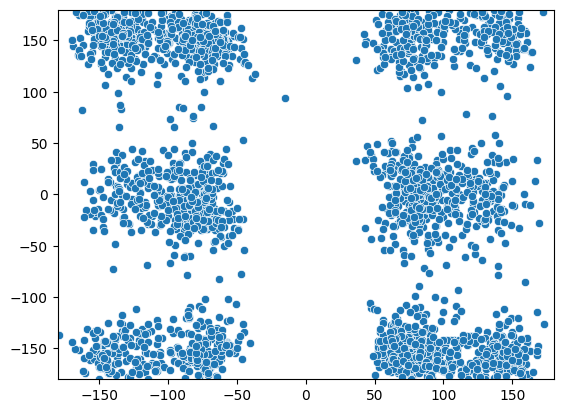

In [42]:
import mdtraj as md

traj = md.load('/Users/reubencohn-gordon/Downloads/ala2 2/sim4/trajectory.dcd', top='/Users/reubencohn-gordon/Downloads/ala2 2/ala2.pdb')
# traj = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')
# table, bonds = traj.topology.to_dataframe() 
# print(table.iloc[0:20])
# # table.iloc[0]

# traj.xyz[-1]
# # samples.shape 


# traj = nnp.expand_dims(traj.xyz, 0) # nnp.reshape(traj, shape=(25000, -1, 3))
# rama_plot(traj[::100])
# traj.xyz.shape

# # find which molecule indices are the AD
print(traj.xyz[0].shape)
# nnp.reshape(traj.xyz[0], (1,688,3))
rama_plot([nnp.reshape(s, (1,2269,3)) for s in traj.xyz[::10, :, :]])

<Axes: >

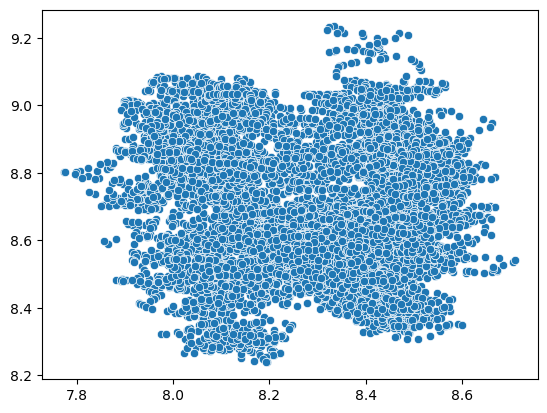

In [20]:
import seaborn as sns
samples
sns.scatterplot(x=samples[::1, 0], y=samples[::1, 1])

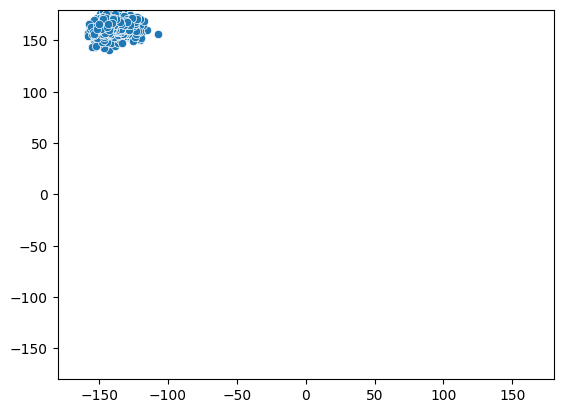

In [56]:
rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[::10, :]])


In [28]:
energ

(Array(24.85553923, dtype=float64, weak_type=True),
 Array(0.82851797, dtype=float64, weak_type=True))

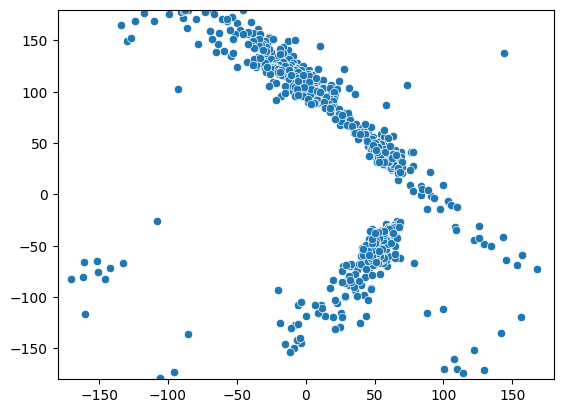

In [22]:
rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[::100, :]])
# samples.shape

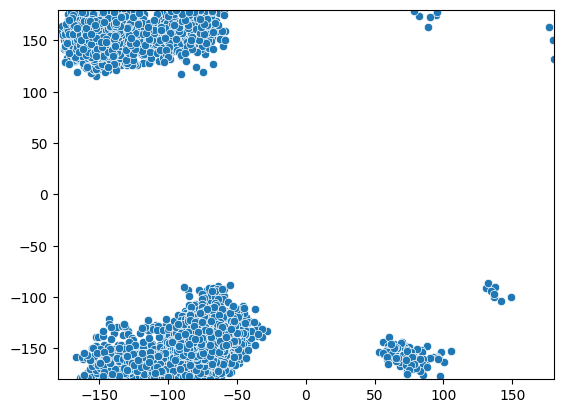

In [59]:
# print(samples)
rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[::10, :]])

In [55]:
L, eps

(Array(45.43126677, dtype=float64, weak_type=True), 1.0)

In [21]:
L, eps

(Array(45.43126677, dtype=float64, weak_type=True), 1e-06)

Array(1.19236483, dtype=float64)

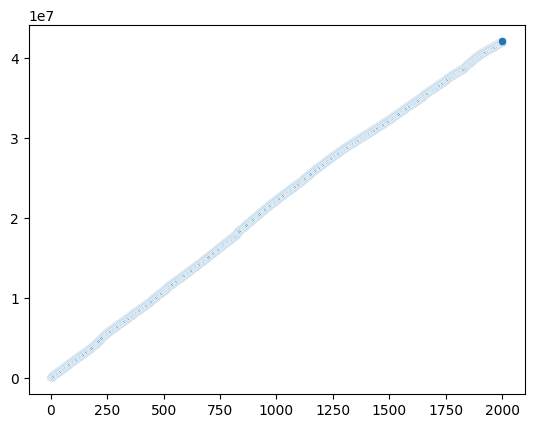

In [48]:
import seaborn as sns

sns.scatterplot(x=nnp.linspace(1,2000, num=2000),y=energy[::10])
nnp.square((energy[1:] - energy[:-1])/math.prod(pos.shape)).mean()

In [23]:
sns.scatterplot(x=nnp.linspace(1,1000, num=1000),y=energy[::10])

ValueError: All arrays must be of the same length

In [17]:
nnp.mean(nnp.square(energy[1:]-energy[:-1])/math.prod(pos.shape))

Array(153151.60597359, dtype=float64)

In [18]:
(nnp.square(energy[1:]-energy[:-1])/math.prod(pos.shape)).mean()

Array(0.10941542, dtype=float64)

In [44]:
L, eps

(Array(0.02621379, dtype=float64), Array(0.02356748, dtype=float64))

In [32]:
from jax_md.simulate import AnnealingSampler

annealingsampler = AnnealingSampler(target, shift_fn=shift_fn)

# ...

In [71]:
samples.shape


(100, 2064)

In [13]:
# ## run nvt

from scipy.constants import k
key = jax.random.PRNGKey(0)

BOLTZMAN = 0.001987191
temperature = 300 * BOLTZMAN
dt = 1e-3
init, update = simulate.nvt_langevin(nlogp, shift_fn, dt, kT=temperature, gamma=0.1)
state = init(key, pos)
traj = []
# gs = []
# cs = []
for i in range(100000):
  if i%10==0:
    traj.append(state.position)
#     gs.append(jax.grad(lambda x : forces.compute(x, box))(state.position))
#     cs.append((lambda x : forces.compute(x, box))(state.position))
    
  state = update(state)
R = state.position
R

Array([[[11.049458 ,  7.793268 , 15.117361 ],
        [11.5900135,  7.5648136, 14.222508 ],
        [11.659822 ,  6.5127535, 14.030108 ],
        ...,
        [19.582058 ,  4.4552236, 13.451371 ],
        [18.621872 ,  4.869699 , 13.701062 ],
        [19.794624 ,  4.4379992, 14.476036 ]]], dtype=float32)

In [121]:
import mdtraj as md
# traj = md.load('/Users/reubencohn-gordon/Downloads/ala2 2/sim4/trajectory.dcd', top='/Users/reubencohn-gordon/Downloads/ala2 2/ala2.pdb')
trajectory = md.load('./data/prod_alanine_dipeptide_amber/structure.pdb')

# nnp.array(traj).squeeze(1).shape 
trajectory.xyz=nnp.array(traj).squeeze(1)[::10]

# trajectory.save_dcd('./data/prod_alanine_dipeptide_amber/traj_langevin.dcd')
trajectory.save_pdb('./data/prod_alanine_dipeptide_amber/traj_langevin.pdb')

In [24]:
# rama_plot(nnp.array(traj)[::10])
# nnp.array(traj).shape
# traj.shape
s = nnp.array(traj)[::100, 0, :, :]
potential_energies = jax.vmap(energy_fn)(s)
# potential_energies

/opt/homebrew/Caskroom/miniconda/base/envs/new/lib/python3.8/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [25]:
potential_energies.mean()

Array(288.07729907, dtype=float64)

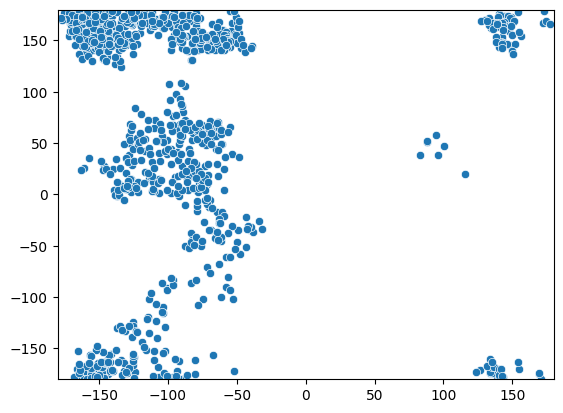

In [65]:
rama_plot(nnp.array(traj)[::10])
# nnp.array(traj).shape

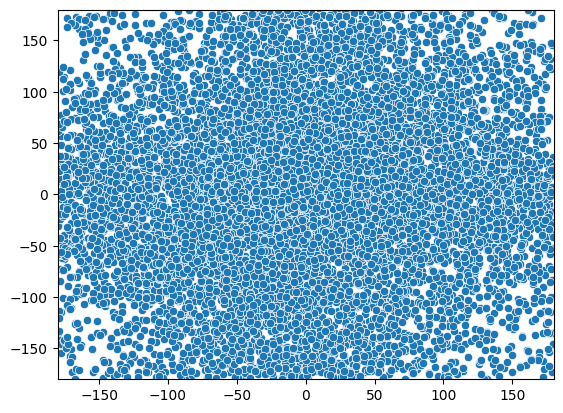

In [33]:
rama_plot(traj)